<h1>Leaf Classification</h1>

## Import needed libraries

In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib import gridspec
from PIL import Image

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, learning_curve, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron, RidgeClassifier, LassoCV, LinearRegression, Ridge, ElasticNet
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import time

# import visualkeras
from ann_visualizer.visualize import ann_viz
from torchviz import make_dot
from torchsummaryX import summary


## Import numerical dataset

In [270]:
train_csv = pd.read_csv('Dataset/train.csv')
print(f"There are {len(train_csv.species.unique())} species in the train set.")
print(f"There are {len(train_csv.id.unique())} images in the train set.")
print(f"There are {train_csv.shape[1]} columns in the train set.")
print(f"There are {train_csv.isnull().sum().sum()} missing values in the train set.")


There are 99 species in the train set.
There are 990 images in the train set.
There are 194 columns in the train set.
There are 0 missing values in the train set.


In [271]:
train_csv.drop('id', axis=1,inplace=False).describe()

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,...,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,0.017412,0.028539,0.031988,0.023280,0.014264,0.038579,0.019202,0.001083,0.007167,0.018639,...,0.036501,0.005024,0.015944,0.011586,0.016108,0.014017,0.002688,0.020291,0.008989,0.019420
std,0.019739,0.038855,0.025847,0.028411,0.018390,0.052030,0.017511,0.002743,0.008933,0.016071,...,0.063403,0.019321,0.023214,0.025040,0.015335,0.060151,0.011415,0.039040,0.013791,0.022768
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001953,0.001953,0.013672,0.005859,0.001953,0.000000,0.005859,0.000000,0.001953,0.005859,...,0.000000,0.000000,0.000977,0.000000,0.004883,0.000000,0.000000,0.000000,0.000000,0.000977
50%,0.009766,0.011719,0.025391,0.013672,0.007812,0.015625,0.015625,0.000000,0.005859,0.015625,...,0.004883,0.000000,0.005859,0.000977,0.012695,0.000000,0.000000,0.003906,0.002930,0.011719
75%,0.025391,0.041016,0.044922,0.029297,0.017578,0.056153,0.029297,0.000000,0.007812,0.027344,...,0.043701,0.000000,0.022217,0.009766,0.021484,0.000000,0.000000,0.023438,0.012695,0.029297
max,0.087891,0.205080,0.156250,0.169920,0.111330,0.310550,0.091797,0.031250,0.076172,0.097656,...,0.429690,0.202150,0.172850,0.200200,0.106450,0.578130,0.151370,0.375980,0.086914,0.141600


In [272]:
print(train_csv.dtypes.value_counts())
print(f"{train_csv.select_dtypes(include=['int64']).columns[0]} is the only int column in the train set.")
print(f"{train_csv.select_dtypes(include=['object']).columns[0]} is the only object column in the train set.")
print(f"There are {train_csv.filter(regex='margin').shape[1]} MARGIN features.")
print(f"There are {train_csv.filter(regex='shape').shape[1]} SHAPE features.")
print(f"There are {train_csv.filter(regex='texture').shape[1]} TEXTURE features.")

float64    192
int64        1
object       1
Name: count, dtype: int64
id is the only int column in the train set.
species is the only object column in the train set.
There are 64 MARGIN features.
There are 64 SHAPE features.
There are 64 TEXTURE features.


# Preprocessing

## Standardization

In [273]:
for column in train_csv.columns[2:]:
    train_csv[column] = StandardScaler().fit_transform(train_csv[column].values.reshape(-1, 1))

In [274]:
train_csv.drop('id', axis=1, inplace=False).describe().round(2)

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
count,990.00,990.00,990.00,990.00,990.00,990.00,990.00,990.0,990.00,990.00,...,990.00,990.00,990.00,990.00,990.00,990.00,990.00,990.00,990.00,990.00
mean,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.0,0.00,0.00,...,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.88,-0.73,-1.24,-0.82,-0.78,-0.74,-1.10,-0.4,-0.80,-1.16,...,-0.58,-0.26,-0.69,-0.46,-1.05,-0.23,-0.24,-0.52,-0.65,-0.85
25%,-0.78,-0.68,-0.71,-0.61,-0.67,-0.74,-0.76,-0.4,-0.58,-0.80,...,-0.58,-0.26,-0.65,-0.46,-0.73,-0.23,-0.24,-0.52,-0.65,-0.81
50%,-0.39,-0.43,-0.26,-0.34,-0.35,-0.44,-0.20,-0.4,-0.15,-0.19,...,-0.50,-0.26,-0.43,-0.42,-0.22,-0.23,-0.24,-0.42,-0.44,-0.34
75%,0.40,0.32,0.50,0.21,0.18,0.34,0.58,-0.4,0.07,0.54,...,0.11,-0.26,0.27,-0.07,0.35,-0.23,-0.24,0.08,0.27,0.43
max,3.57,4.55,4.81,5.16,5.28,5.23,4.15,11.0,7.73,4.92,...,6.20,10.21,6.76,7.54,5.89,9.38,13.03,9.12,5.65,5.37


## Correlation Analysis

- Correlation between margin features

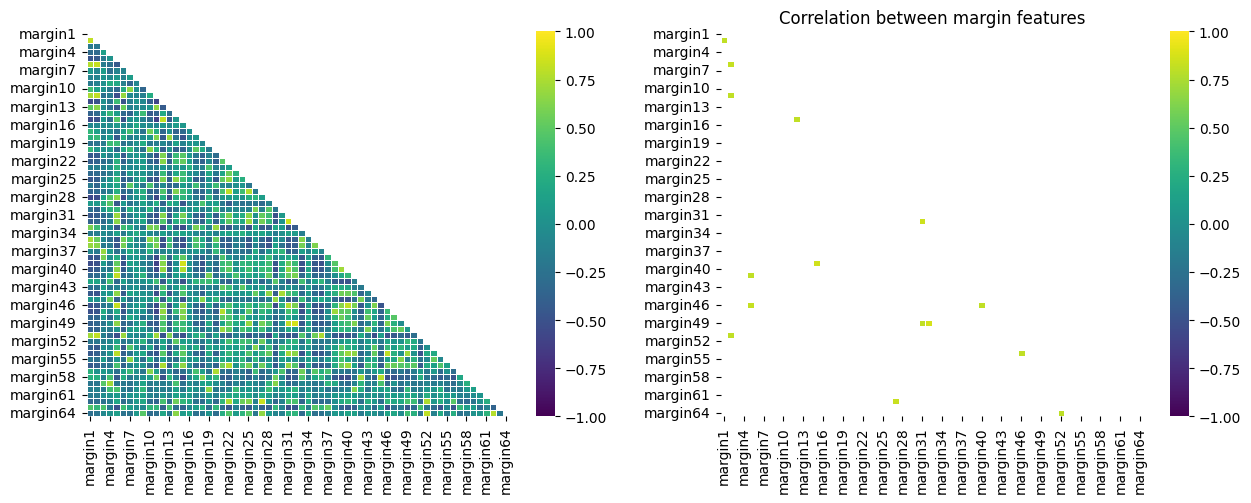

There are 64 MARGIN features in the train set.
margin1 and margin2 have high correlation = 0.81
margin2 and margin6 have high correlation = 0.83
margin2 and margin11 have high correlation = 0.81
margin2 and margin51 have high correlation = 0.81
margin5 and margin41 have high correlation = 0.81
margin5 and margin46 have high correlation = 0.83
margin12 and margin15 have high correlation = 0.81
margin15 and margin39 have high correlation = 0.85
margin27 and margin62 have high correlation = 0.83
margin31 and margin32 have high correlation = 0.85
margin31 and margin49 have high correlation = 0.81
margin32 and margin49 have high correlation = 0.87
margin40 and margin46 have high correlation = 0.81
margin46 and margin54 have high correlation = 0.81
margin52 and margin64 have high correlation = 0.8


In [275]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
margin_corr = train_csv.filter(regex='margin').corr()
sns.heatmap(margin_corr,vmin=-1, vmax=1, center=0, cmap='viridis', mask=np.triu(np.ones_like(margin_corr,dtype=bool)), linewidths=0.5, ax=ax[0])
sns.heatmap(margin_corr,vmin=-1, vmax=1, center=0, cmap='viridis', mask= np.triu(np.ones_like(margin_corr, dtype=bool))|(np.abs(margin_corr) <= 0.8)  , linewidths=0.5, ax=ax[1])
plt.title('Correlation between margin features')
plt.show()
print(f"There are {train_csv.filter(regex='margin').shape[1]} MARGIN features in the train set.")
for i in range(len(margin_corr)):
    for j in range(i+1,len(margin_corr)):
        if i != j and abs(margin_corr.iloc[i,j]) >= 0.8:
            print(f"{margin_corr.columns[i]} and {margin_corr.columns[j]} have high correlation = {round(margin_corr.iloc[i,j],2)}")

- Correlation between Shape features

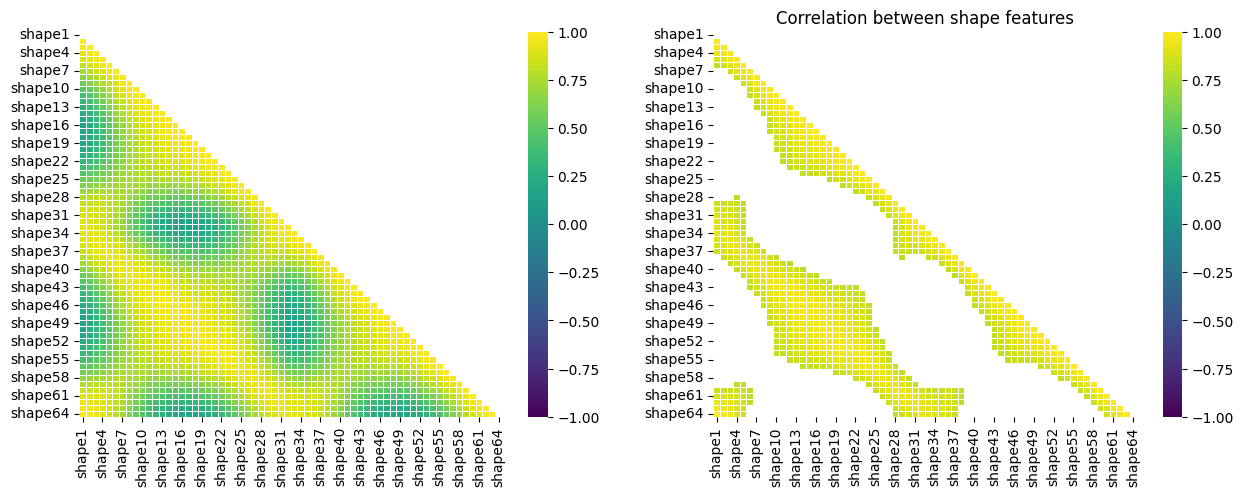

There are 64 SHAPE features in the train set.
shape1 and shape2 have high correlation = 0.99
shape1 and shape3 have high correlation = 0.96
shape1 and shape4 have high correlation = 0.93
shape1 and shape5 have high correlation = 0.88
shape1 and shape6 have high correlation = 0.81
shape1 and shape29 have high correlation = 0.83
shape1 and shape30 have high correlation = 0.87
shape1 and shape31 have high correlation = 0.89
shape1 and shape32 have high correlation = 0.9
shape1 and shape33 have high correlation = 0.91
shape1 and shape34 have high correlation = 0.91
shape1 and shape35 have high correlation = 0.9
shape1 and shape36 have high correlation = 0.88
shape1 and shape37 have high correlation = 0.84
shape1 and shape60 have high correlation = 0.84
shape1 and shape61 have high correlation = 0.9
shape1 and shape62 have high correlation = 0.94
shape1 and shape63 have high correlation = 0.97
shape1 and shape64 have high correlation = 0.99
shape2 and shape3 have high correlation = 0.99
sha

In [276]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
shape_corr = train_csv.filter(regex='shape').corr()
sns.heatmap(shape_corr,vmin=-1, vmax=1, center=0, cmap='viridis', mask=np.triu(np.ones_like(shape_corr,dtype=bool)), linewidths=0.5, ax=ax[0])
sns.heatmap(shape_corr,vmin=-1, vmax=1, center=0, cmap='viridis', mask= np.triu(np.ones_like(shape_corr, dtype=bool))|(np.abs(shape_corr) <= 0.8)  , linewidths=0.5, ax=ax[1])
plt.title('Correlation between shape features')
plt.show()
print(f"There are {train_csv.filter(regex='shape').shape[1]} SHAPE features in the train set.")
for i in range(len(shape_corr)):
    for j in range(i+1,len(shape_corr)):
        if i != j and abs(shape_corr.iloc[i,j]) >= 0.8:
            print(f"{shape_corr.columns[i]} and {shape_corr.columns[j]} have high correlation = {round(shape_corr.iloc[i,j],2)}")

- Correlation between Texture features

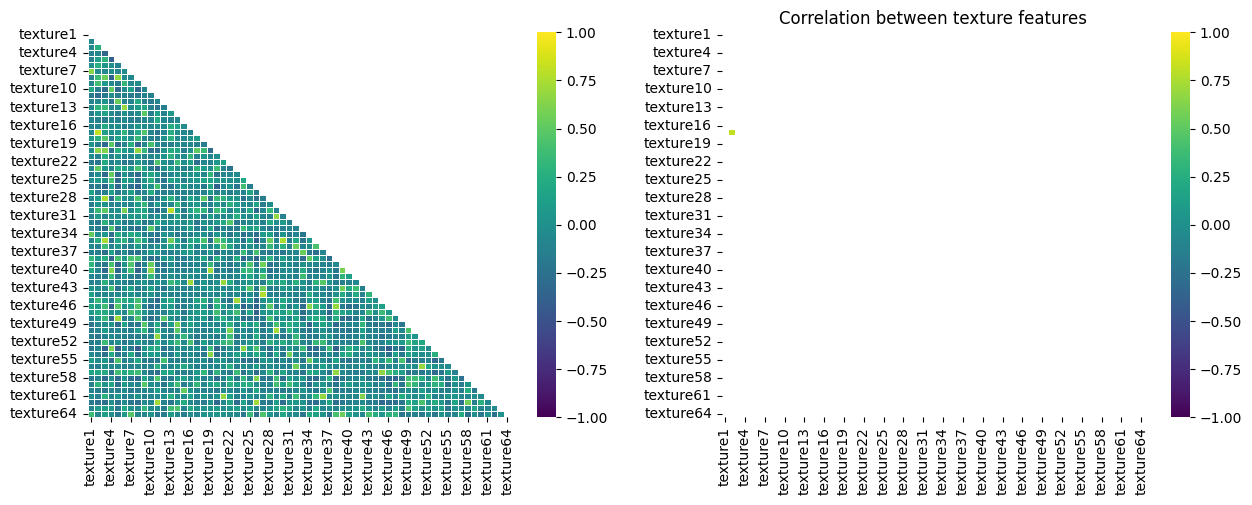

There are 64 TEXTURE features in the train set.
texture2 and texture17 have high correlation = 0.82


In [277]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
texture_corr = train_csv.filter(regex='texture').corr()
sns.heatmap(texture_corr,vmin=-1, vmax=1, center=0, cmap='viridis', mask=np.triu(np.ones_like(texture_corr,dtype=bool)), linewidths=0.5, ax=ax[0])
sns.heatmap(texture_corr,vmin=-1, vmax=1, center=0, cmap='viridis', mask= np.triu(np.ones_like(texture_corr, dtype=bool))|(np.abs(texture_corr) <= 0.8)  , linewidths=0.5, ax=ax[1])
plt.title('Correlation between texture features')
plt.show()
print(f"There are {train_csv.filter(regex='texture').shape[1]} TEXTURE features in the train set.")
for i in range(len(texture_corr)):
    for j in range(i+1,len(texture_corr)):
        if i != j and abs(texture_corr.iloc[i,j]) >= 0.8:
            print(f"{texture_corr.columns[i]} and {texture_corr.columns[j]} have high correlation = {round(texture_corr.iloc[i,j],2)}")

In [278]:
corr = train_csv.drop(['id','species'],axis=1).corr()
for i in range(len(corr)):
    for j in range(i+1,len(corr)):
        if  i != j and abs(corr.iloc[i,j]) >= 0.8:
            print(f"{corr.columns[i]} and {corr.columns[j]} have high correlation = {round(corr.iloc[i,j],2)}")

margin1 and margin2 have high correlation = 0.81
margin2 and margin6 have high correlation = 0.83
margin2 and margin11 have high correlation = 0.81
margin2 and margin51 have high correlation = 0.81
margin5 and margin41 have high correlation = 0.81
margin5 and margin46 have high correlation = 0.83
margin12 and margin15 have high correlation = 0.81
margin15 and margin39 have high correlation = 0.85
margin27 and margin62 have high correlation = 0.83
margin31 and margin32 have high correlation = 0.85
margin31 and margin49 have high correlation = 0.81
margin32 and margin49 have high correlation = 0.87
margin40 and margin46 have high correlation = 0.81
margin46 and margin54 have high correlation = 0.81
margin52 and margin64 have high correlation = 0.8
shape1 and shape2 have high correlation = 0.99
shape1 and shape3 have high correlation = 0.96
shape1 and shape4 have high correlation = 0.93
shape1 and shape5 have high correlation = 0.88
shape1 and shape6 have high correlation = 0.81
shape1 an

## Label Encoding

In [279]:
labels = LabelEncoder().fit_transform(train_csv.species)
X = train_csv.drop(['id','species'],axis=1)
X.head()

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,-0.486611,-0.131357,-0.330956,-0.682244,-0.138444,-0.554066,0.465218,-0.395064,-0.584019,0.906636,...,-0.452710,-0.260149,-0.560872,-0.345848,1.242752,-0.233151,-0.23561,-0.394871,-0.652143,0.262397
1,-0.585602,-0.734880,-0.028561,-0.269558,0.605389,-0.704306,0.018812,-0.395064,-0.802765,-0.674054,...,-0.560567,-0.260149,-0.687151,-0.423884,0.478218,-0.233151,-0.23561,-0.494974,2.181670,0.133641
2,-0.585602,-0.483408,-0.482192,-0.544694,-0.563515,-0.629196,2.808662,-0.395064,-0.802765,1.636190,...,1.858873,-0.260149,-0.434636,-0.423884,-0.541291,-0.233151,-0.23561,-0.520012,0.835641,-0.724631
3,-0.882575,-0.634302,-0.330956,-0.613469,0.392826,-0.366289,0.242044,-0.395064,0.728566,-0.066082,...,-0.575984,-0.209558,-0.687151,-0.462921,0.287052,-0.233151,-0.23561,-0.069525,-0.652143,1.249425
4,-0.585602,-0.634302,0.651866,-0.475883,-0.032190,-0.441400,-0.762355,-0.395064,-0.802765,-0.795636,...,0.949628,-0.260149,0.238782,-0.462921,-1.050981,-0.233151,-0.23561,-0.520012,-0.652143,0.519866


## Train Test Split

In [280]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=43,stratify=y)
print(f"X_train shape = {X_train.shape}")
print(f"X_test shape = {X_test.shape}")
print(f"y_train shape = {y_train.shape}")
print(f"y_test shape = {y_test.shape}")

X_train shape = (792, 192)
X_test shape = (198, 192)
y_train shape = (792,)
y_test shape = (198,)


# MLP

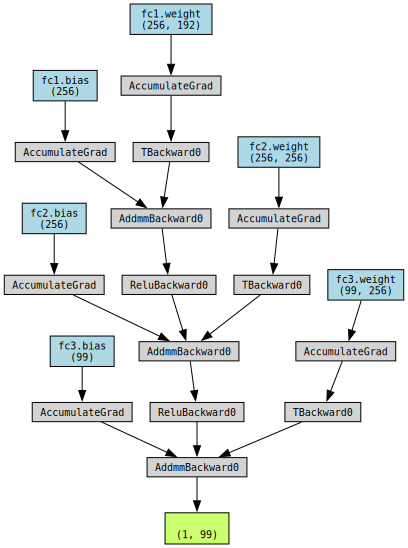

In [281]:
class MLP(nn.Module):
    def __init__(self, input_size=192, hidden_size=256, num_classes=99):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x


model = MLP()
make_dot(model(torch.randn(1, 192)), params=dict(model.named_parameters()))


In [282]:
writer = SummaryWriter('runs/mlp'+time.strftime("%Y%m%d-%H%M%S"))
writer.add_graph(model, torch.randn(1, 192))
writer.close()

In [305]:
batch_size = 64

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)

# Create a train DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

# Create a test DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [308]:
n_hidden = 512
model = MLP(X_train.shape[1], n_hidden, X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 1000

min_loss_epoch = 0
min_loss_value = -1
best_model_weights_paths = {}
best_val_loss = float('inf')  # Initialize with a large value
best_epoch = -1
best_model_weights = None
train_losses = []
val_losses = []

writer = SummaryWriter('runs/mlp-nn'+time.strftime("%Y%m%d-%H%M%S"))

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for x, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_dataset)
    train_losses.append(train_loss)
    
    # Validation loop
    model.eval()  
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for x_val, labels in test_loader:
            outputs = model(x_val)
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    accuracy = correct_predictions / total_samples
    val_loss = 1-accuracy
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_model = model

    writer.add_scalar('Training Loss', train_loss, epoch)
    writer.add_scalar('Validation Loss', val_loss, epoch)

writer.close()

Epoch 1000/1000: 100%|██████████| 13/13 [00:00<00:00, 300.56batch/s]


In [309]:
print(val_losses[best_epoch])
print(best_epoch)
print(best_val_loss)

0.010101010101010055
41
0.010101010101010055


Training accuracy = 100.0%
Validation accuracy = 99.0%
Best Validation Epoch = 41


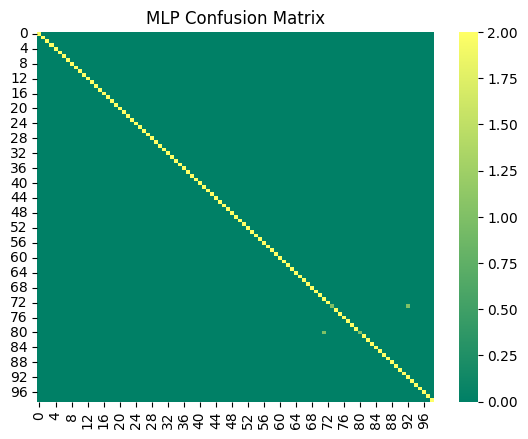

In [312]:
print(f"Training accuracy = {round(accuracy_score(y_train_tensor, torch.max(best_model(X_train_tensor), 1)[1]),4)*100}%")
print(f"Validation accuracy = {round(accuracy_score(y_test_tensor, predictions),3)*100}%")
print(f"Best Validation Epoch = {best_epoch}")

predictions = best_model(X_test_tensor)
predictions = torch.max(predictions, 1)[1]
sns.heatmap(confusion_matrix(y_test_tensor, predictions), annot=False, fmt='g', cmap='summer')
plt.title('MLP Confusion Matrix')
plt.show()

- View Sample of images

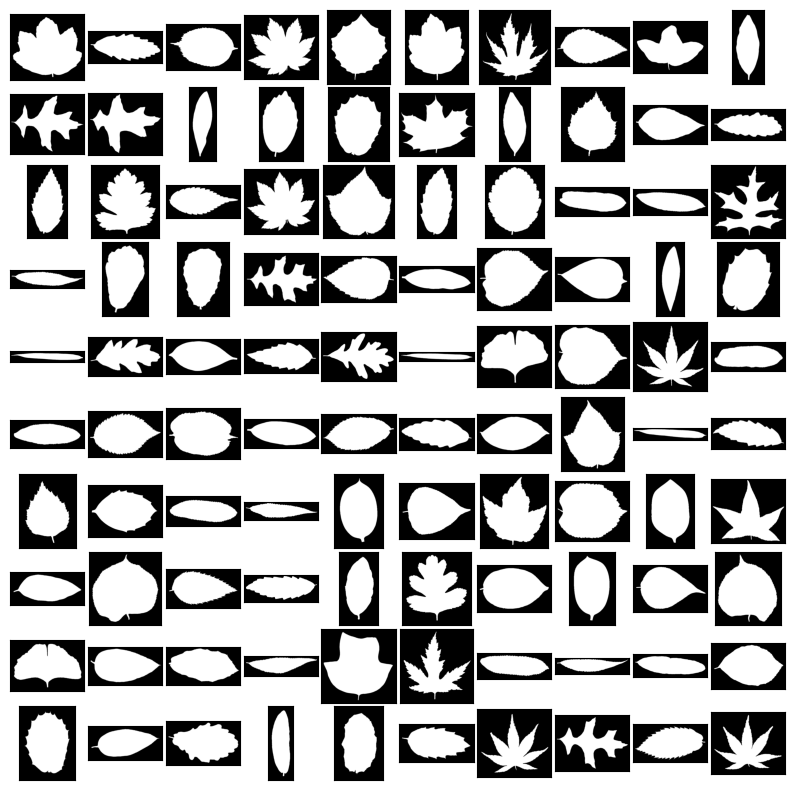

In [195]:
image_folder = "Dataset/images/"
image_filenames = sorted(os.listdir(image_folder))

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10, wspace=0.05, hspace=0.05)

for i, image_filename in enumerate(image_filenames[:100]):
    image_path = os.path.join(image_folder, image_filename)
    img = Image.open(image_path).convert('1') # '1' for black/white
    ax = plt.subplot(gs[i])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(img)

plt.show()